In [10]:
import pandas as pd

cars =  pd.read_csv('cars_clean.csv', low_memory=False)[:5000]
cars = cars.drop(["doors", "num_seats"], axis=1)

if "title" in cars.columns:
    cars = cars.drop(["title", "url"], axis=1)

In [18]:
def set_color(_fig, _ax):
    _fig.patch.set_facecolor('#1b212c')
    _ax.patch.set_facecolor('#1b212c')
    _ax.spines['bottom'].set_color('white')
    _ax.spines['top'].set_color('white')
    _ax.spines['left'].set_color('white')
    _ax.spines['right'].set_color('white')
    _ax.xaxis.label.set_color('white')
    _ax.yaxis.label.set_color('white')
    _ax.grid(alpha=0.1)
    _ax.title.set_color('white')
    _ax.tick_params(axis='x', colors='white')
    _ax.tick_params(axis='y', colors='white')

In [11]:
from tqdm import tqdm

corresponding_value = dict()

for col in tqdm(cars.columns):
    if cars[col].dtype == 'object' or col == 'first_registration':
        cars[col] = pd.Categorical(cars[col])
        cars[col] = cars[col].cat.codes
    elif cars[col].dtype == 'float64':
        cars[col] = cars[col].astype('float32')

#for col in ['doors', 'emission_class', 'num_of_owners', 'num_seats', 'cabrio', 'kleinwagen', 'limousine', 'sportwagen','gelaendewagen','van', 'kombi']:
for col in ['emission_class', 'num_of_owners', 'cabrio', 'kleinwagen', 'limousine', 'sportwagen','gelaendewagen','van', 'kombi']:
    if col in cars.columns:
        cars[col] = pd.Categorical(cars[col])
        cars[col] = cars[col].cat.codes


print(cars.dtypes)



100%|██████████| 24/24 [00:00<00:00, 1333.78it/s]

airbag                   int8
climate_control          int8
co2                   float32
color                    int8
condition                int8
consumption           float32
cubicCapacity         float32
emission_class           int8
first_registration       int8
fuel                     int8
gear                     int8
interior                 int8
manufacturer             int8
mileage               float32
num_of_owners            int8
power                 float32
price                 float32
cabrio                   int8
kleinwagen               int8
kombi                    int8
limousine                int8
sportwagen               int8
gelaendewagen            int8
van                      int8
dtype: object


In [12]:
import numpy as np

y = cars['price']
x = cars.drop(['price'], axis=1)

# split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42069)

cars_categorial = x_train.select_dtypes(include=['int8', 'int64'])
cars_numerical = x_train.select_dtypes(include=['float32'])

print(len(cars_numerical.columns))

5


In [13]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        if len(self.x) > 20:
            plt.plot(self.x[len(self.x)-20:], self.losses[len(self.x)-20:], label="loss")
            plt.plot(self.x[len(self.x)-20:], self.val_losses[len(self.x)-20:], label="val_loss")
        else:
            plt.plot(self.x, self.losses, label="loss")
            plt.plot(self.x, self.val_losses, label="val_loss")

        plt.legend()
        plt.show()

plot_losses = PlotLosses()

In [14]:
from keras import Input
from keras.layers import Reshape, Embedding

inputs = []
embeddings = []
for c in range(len(cars_categorial.columns)):
    input_ = Input(shape=(1,),name='input_'+str(cars_categorial.columns[c]).replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
    no_of_unique_cat  = len(cars_categorial.iloc[:,c].unique())
    embedding_size = min(np.ceil(no_of_unique_cat/2), 50 )
    embedding_size = int(embedding_size)
    embedding = Embedding(no_of_unique_cat+1, embedding_size, input_length = 1,name='embedding_'+str(cars_categorial.columns[c]).replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))(input_)
    embedding = Reshape(target_shape=(embedding_size,),name='reshape_'+str(cars_categorial.columns[c]).replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))(embedding)
    inputs.append(input_)
    embeddings.append(embedding)

cat_concat = tf.keras.layers.Concatenate(name="concat_categorical")(embeddings)
cat_dense = tf.keras.layers.Dense(4096, activation='selu', kernel_initializer='lecun_normal')(cat_concat)

input_numeric = tf.keras.layers.Input(shape=(len(cars_numerical.columns),), name='input_continuous')
# batch_norm = tf.keras.layers.BatchNormalization(name='batch_norm')(input_numeric)
norm = tf.keras.layers.LayerNormalization(axis=1)(input_numeric)
inputs.append(input_numeric)
numeric_dense = tf.keras.layers.Dense(4096, activation='selu', kernel_initializer='lecun_normal')(norm)

x = tf.keras.layers.Concatenate(name="concat")([numeric_dense, cat_dense])

x = tf.keras.layers.Dense(2048, activation='selu', kernel_initializer='lecun_normal')(x)
x = tf.keras.layers.Dense(1024, activation='selu', kernel_initializer='lecun_normal')(x)
x = tf.keras.layers.Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)
x = tf.keras.layers.Dense(1024, activation='selu', kernel_initializer='lecun_normal')(x)
x = tf.keras.layers.Dense(2048, activation='selu', kernel_initializer='lecun_normal')(x)

out = tf.keras.layers.Dense(1, activation='relu', name='output')(x)


In [15]:
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(optimizer='adam',
              loss='mean_absolute_error', metrics=['mean_absolute_error'])


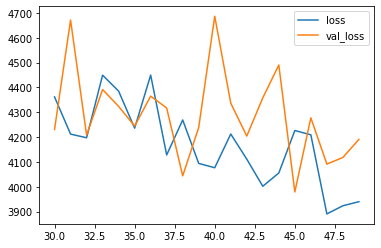

13/13 [==============================] - 3s 189ms/step - loss: 3939.9824 - mean_absolute_error: 3939.9824 - val_loss: 4190.5972 - val_mean_absolute_error: 4190.5972


In [16]:
hist = model.fit([cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical], y_train, epochs=50, batch_size=300, callbacks=[plot_losses], validation_split=0.14)


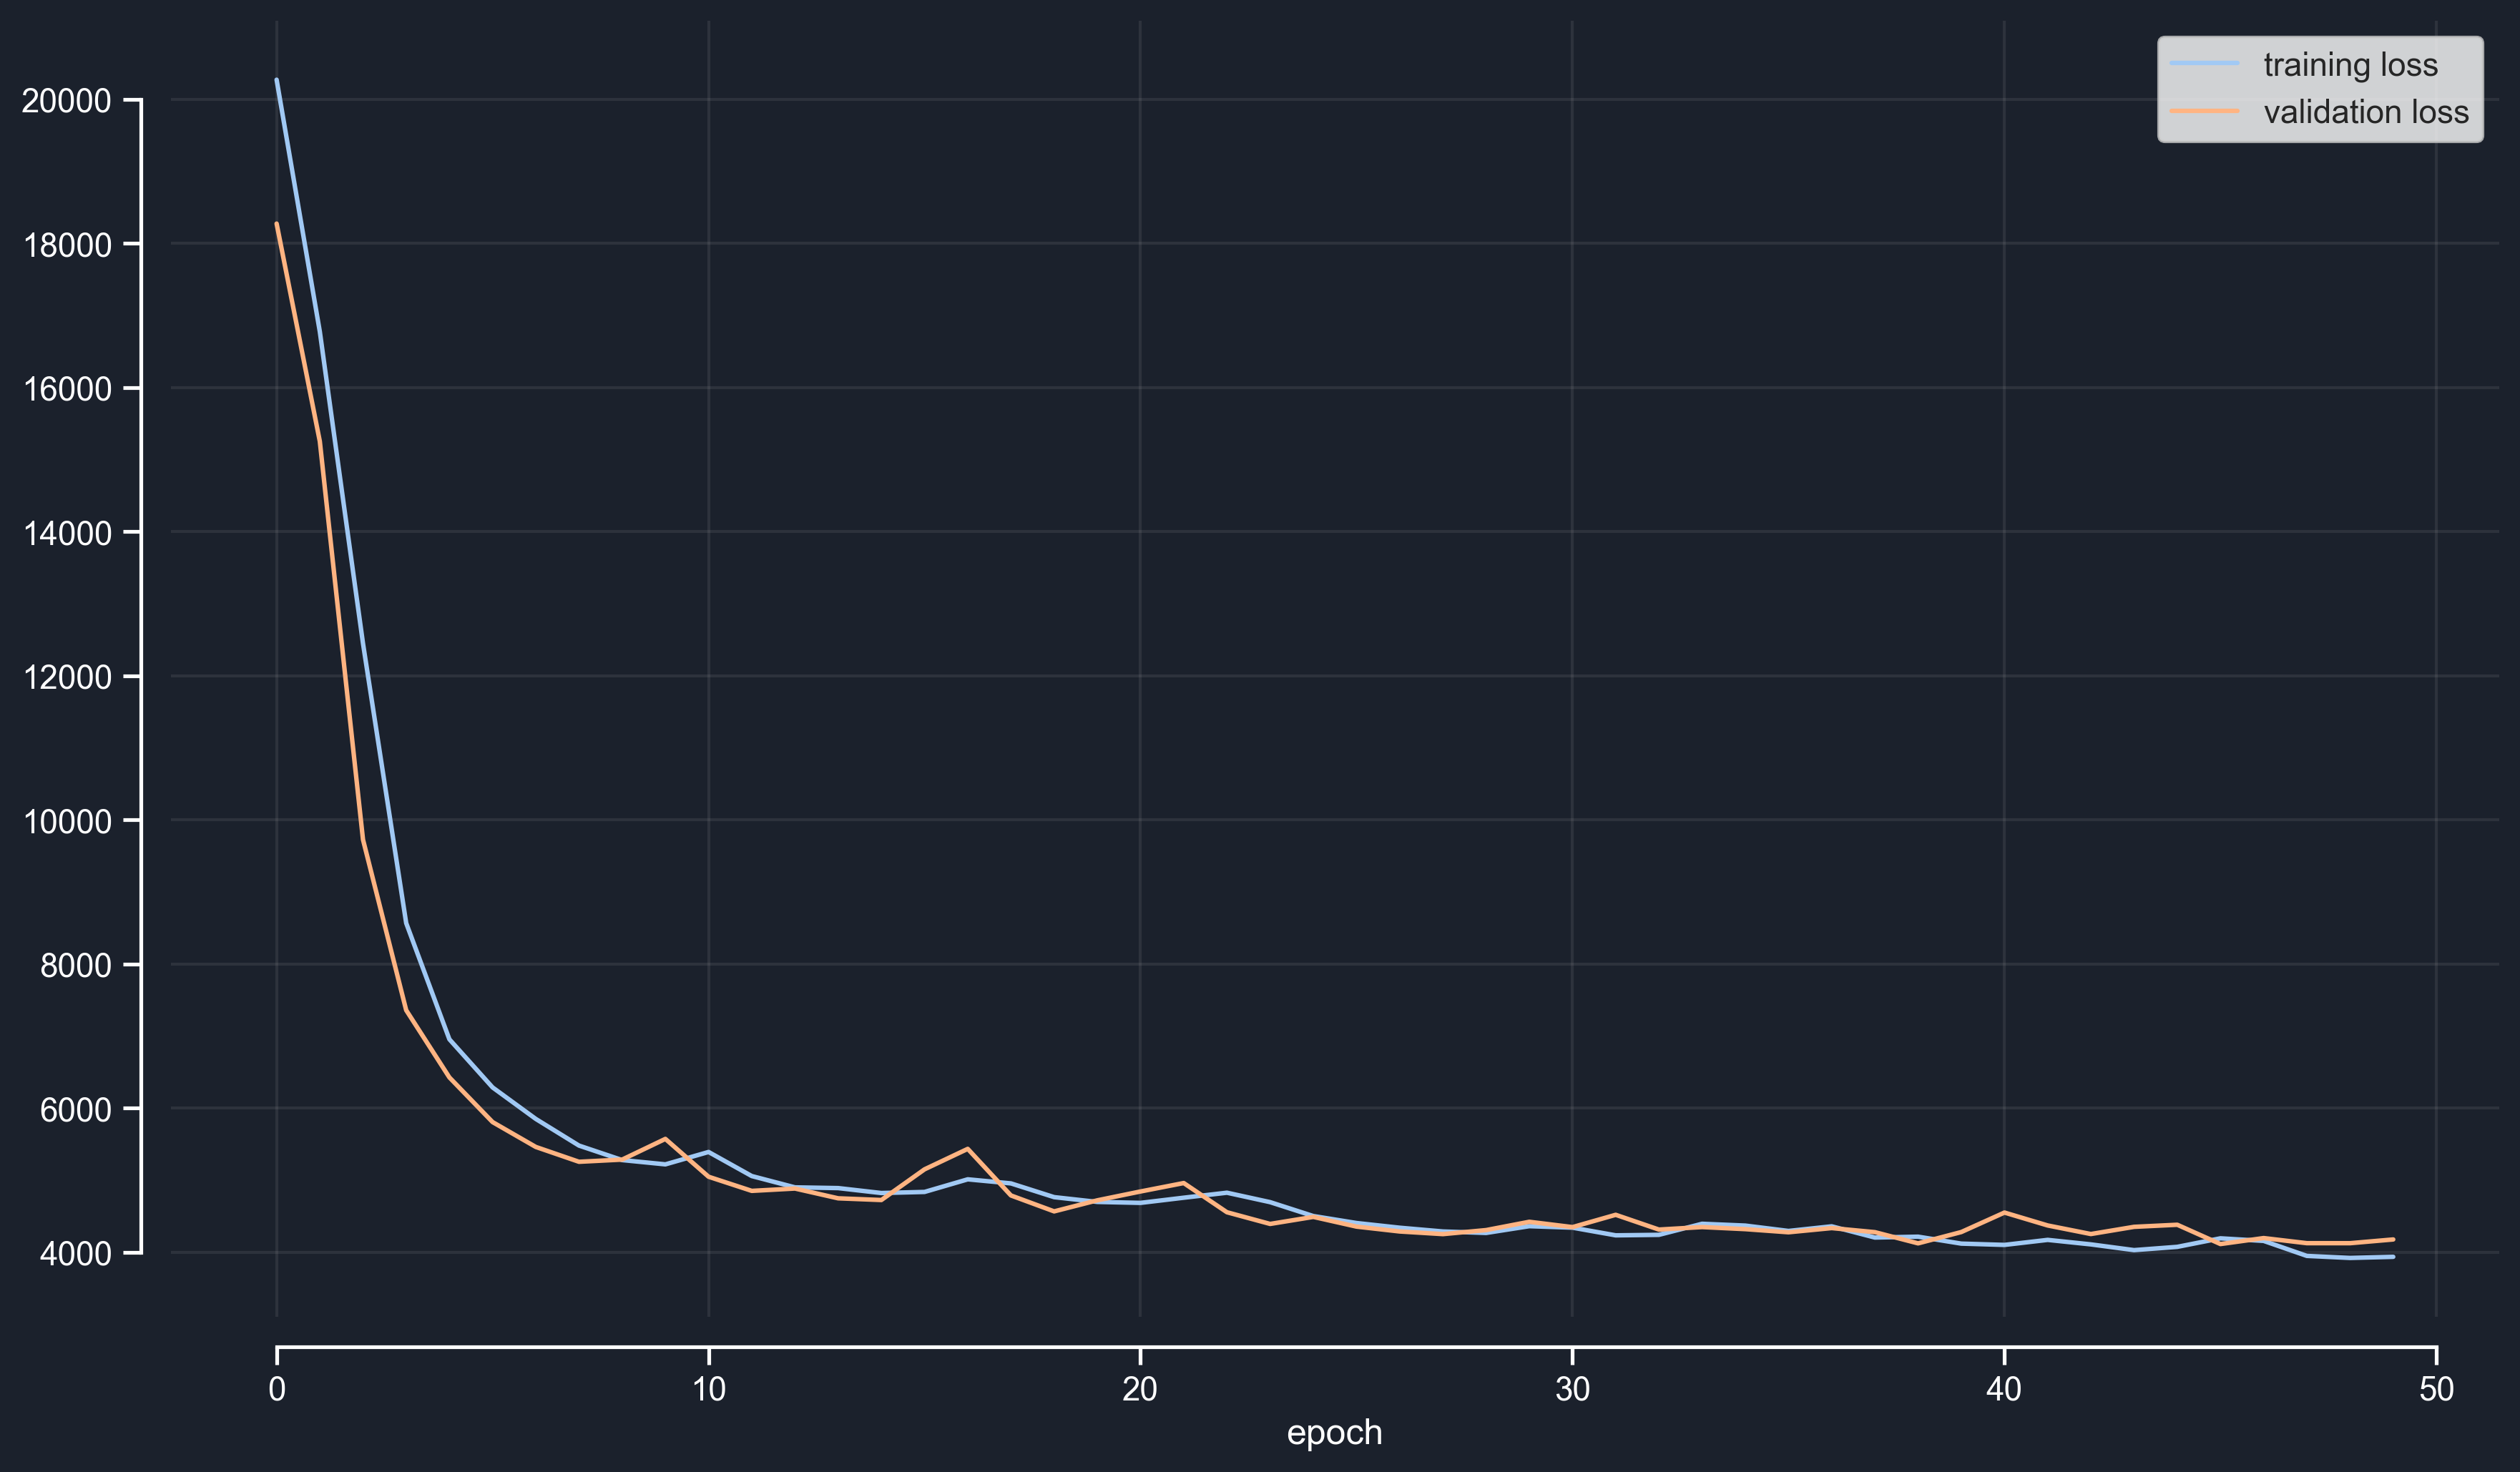

In [60]:
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)

hist_df = pd.DataFrame(hist.history)
sns.lineplot(x=hist_df.index, y=gaussian_filter1d(hist_df.loss, 0.6), ax=ax, label='training loss')
sns.lineplot(x=hist_df.index, y=gaussian_filter1d(hist_df.val_loss, 0.6), ax=ax, label='validation loss')
set_color(fig, ax)
sns.despine(offset=10, trim=True)
plt.xlabel('epoch')
plt.show()

In [8]:
from sklearn.metrics import r2_score

cars_categorial = x_test.select_dtypes(include=['int8', 'int64'])
cars_numerical = x_test.select_dtypes(include=['float32'])

r2_score(y_test,model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical]))


0.9012342912990071

In [9]:
# print mean absolute error
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical])))

3677.7683


In [10]:
# print mean squared error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical]))**0.5)

6789.207317500328


In [11]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical]))

0.19275737

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


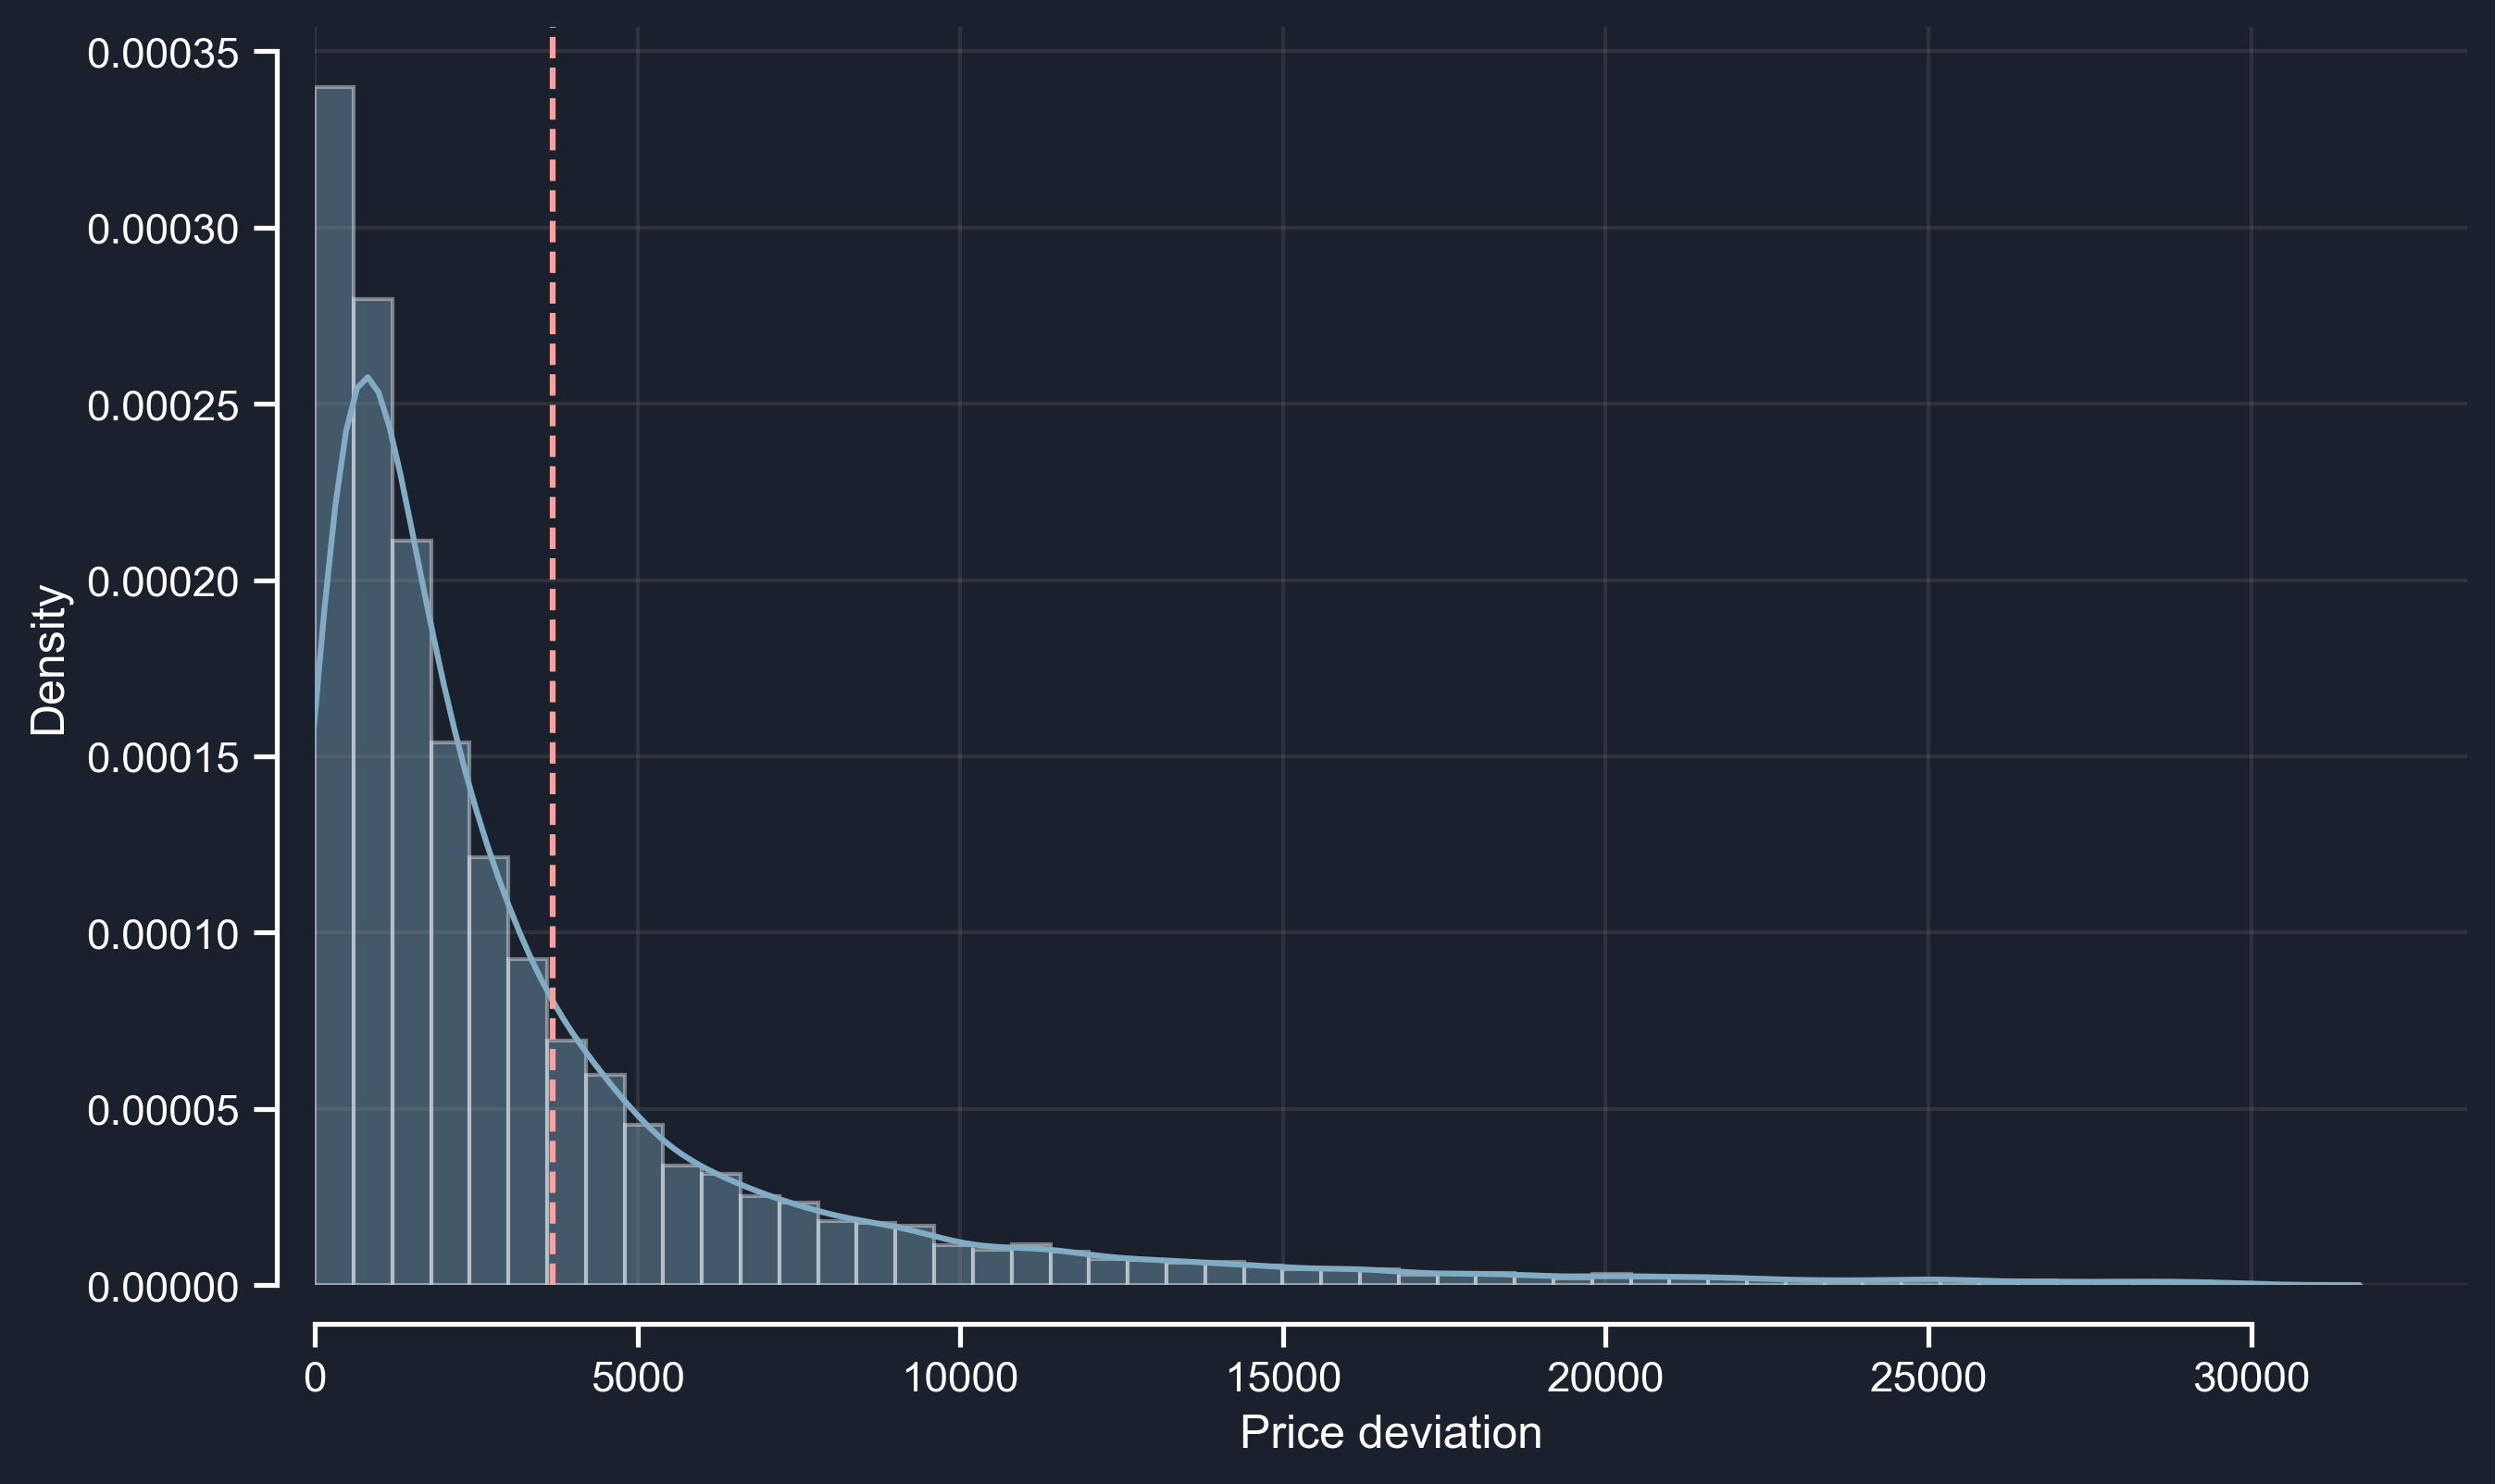

In [20]:
df = pd.DataFrame()
import seaborn as sns

def set_color(_fig, _ax):
    _fig.patch.set_facecolor('#1b212c')
    _ax.patch.set_facecolor('#1b212c')
    _ax.spines['bottom'].set_color('white')
    _ax.spines['top'].set_color('white')
    _ax.spines['left'].set_color('white')
    _ax.spines['right'].set_color('white')
    _ax.xaxis.label.set_color('white')
    _ax.yaxis.label.set_color('white')
    _ax.grid(alpha=0.1)
    _ax.title.set_color('white')
    _ax.tick_params(axis='x', colors='white')
    _ax.tick_params(axis='y', colors='white')

# add a column to y_test with the actual values
df['actual'] = y_test

# add a column to y_pred with the predicted value
df['predicted'] = model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical])

df['diff'] = abs(df['actual'] - df['predicted'])

df2 = df[df["diff"] < 30000]

sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
sns.distplot(df2["diff"], color="#81acc3", hist_kws=dict(alpha=0.4), fit_kws=dict(alpha=1), ax=ax)

plt.axvline(np.mean(df["diff"]), color='r', linestyle='--', label='Median')

sns.despine(offset=10, trim=True)
set_color(fig, ax)
plt.xlabel('Price deviation')
plt.xlim(0, None)
plt.savefig('./tree_error_dist.png', dpi=300)
plt.show()

In [61]:
model.save('model.keras')

In [13]:
"""
cars_categorial = x_test.select_dtypes(include=['int8', 'int64'])
cars_numerical = x_test.select_dtypes(include=['float32'])
y_pred = model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical])
baseline = mean_absolute_error(y_test, y_pred)
"""

"\ncars_categorial = x_test.select_dtypes(include=['int8', 'int64'])\ncars_numerical = x_test.select_dtypes(include=['float32'])\ny_pred = model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical])\nbaseline = mean_absolute_error(y_test, y_pred)\n"

In [14]:
# for each column name
"""
import numpy as np

weights = dict()
for i in range(len(x_train.columns)):
    n = 50
    values = []
    for _ in range(n):
        x_test_ = x_test.copy(True)

        min_ = x_test_[x_train.columns[i]].min()
        max_ = x_test_[x_train.columns[i]].max()

        if x_test_.dtypes[i] == 'int64' or x_test_.dtypes[i] == 'int8':
            x_test_[x_train.columns[i]] = np.random.randint(min_, max_, size=len(x_test_))
        else:
            x_test_[x_train.columns[i]] = np.random.uniform(min_, max_, size=len(x_test_))
            x_test_[x_train.columns[i]] = x_test_[x_train.columns[i]].astype('float32')

        cars_categorial = x_test_.select_dtypes(include=['int8', 'int64'])
        cars_numerical = x_test_.select_dtypes(include=['float32'])
        y_pred = model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical])
        values.append(mean_absolute_error(y_test, y_pred))

    weights[x_train.columns[i]] = abs(np.mean(values)-baseline)
    print(x_train.columns[i], abs(np.mean(values)-baseline))
"""


"\nimport numpy as np\n\nweights = dict()\nfor i in range(len(x_train.columns)):\n    n = 50\n    values = []\n    for _ in range(n):\n        x_test_ = x_test.copy(True)\n\n        min_ = x_test_[x_train.columns[i]].min()\n        max_ = x_test_[x_train.columns[i]].max()\n\n        if x_test_.dtypes[i] == 'int64' or x_test_.dtypes[i] == 'int8':\n            x_test_[x_train.columns[i]] = np.random.randint(min_, max_, size=len(x_test_))\n        else:\n            x_test_[x_train.columns[i]] = np.random.uniform(min_, max_, size=len(x_test_))\n            x_test_[x_train.columns[i]] = x_test_[x_train.columns[i]].astype('float32')\n\n        cars_categorial = x_test_.select_dtypes(include=['int8', 'int64'])\n        cars_numerical = x_test_.select_dtypes(include=['float32'])\n        y_pred = model.predict(x=[cars_categorial[x] for x in cars_categorial.columns] + [cars_numerical])\n        values.append(mean_absolute_error(y_test, y_pred))\n\n    weights[x_train.columns[i]] = abs(np.mean(

In [15]:
# plot it
"""
import matplotlib.pyplot as plt

# sort the weights
sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)

# plot the weights
plt.bar(range(len(sorted_weights)), [x[1] for x in sorted_weights])
plt.xticks(range(len(sorted_weights)), [x[0] for x in sorted_weights])

# make the names of the x axis more readable
plt.xticks(rotation=90)

plt.show()
"""

'\nimport matplotlib.pyplot as plt\n\n# sort the weights\nsorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)\n\n# plot the weights\nplt.bar(range(len(sorted_weights)), [x[1] for x in sorted_weights])\nplt.xticks(range(len(sorted_weights)), [x[0] for x in sorted_weights])\n\n# make the names of the x axis more readable\nplt.xticks(rotation=90)\n\nplt.show()\n'

In [16]:
# to_drop = [x[0] for x in list(weights.items()) if x[1] <weights["gear"]]


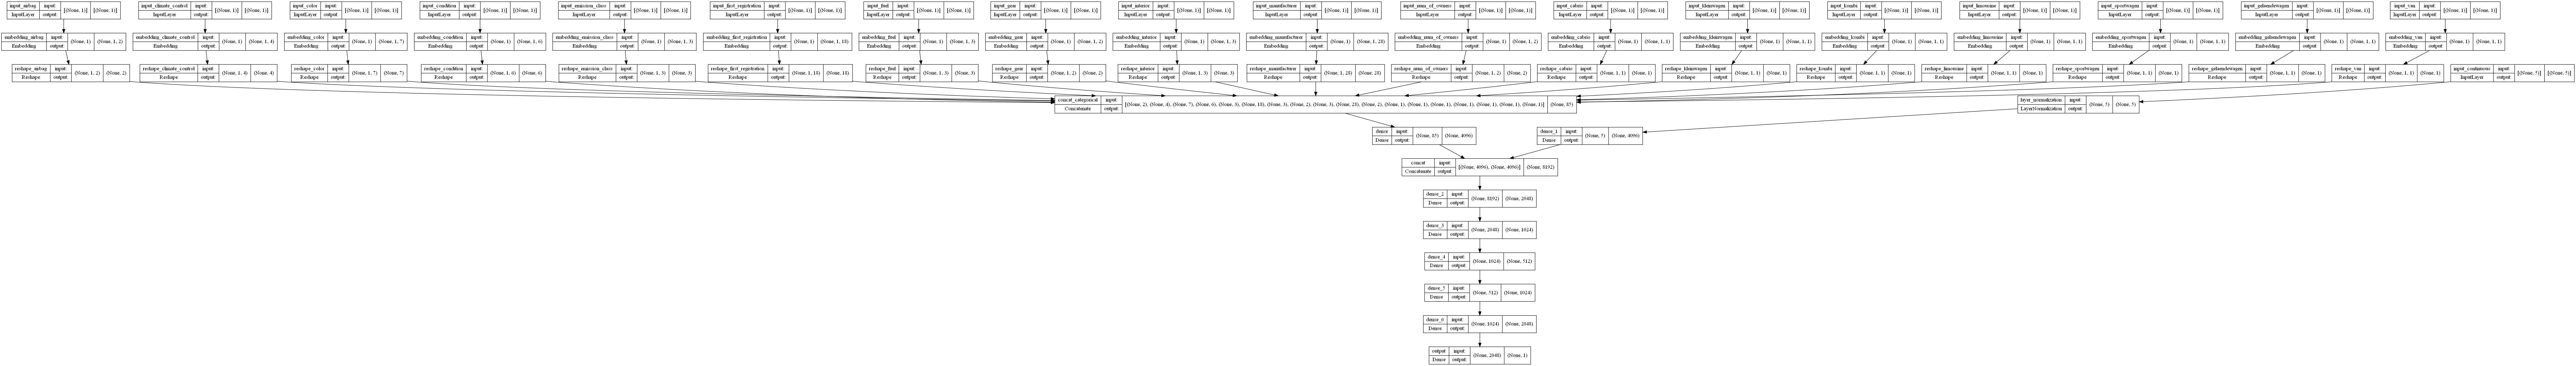

In [11]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt


In [12]:
def set_color(_fig, _ax):
    _fig.patch.set_facecolor('#1b212c')
    _ax.patch.set_facecolor('#1b212c')
    _ax.spines['bottom'].set_color('white')
    _ax.spines['top'].set_color('white')
    _ax.spines['left'].set_color('white')
    _ax.spines['right'].set_color('white')
    _ax.xaxis.label.set_color('white')
    _ax.yaxis.label.set_color('white')
    _ax.grid(alpha=0.1)
    _ax.title.set_color('white')
    _ax.tick_params(axis='x', colors='white')
    _ax.tick_params(axis='y', colors='white')

TypeError: plot_model() got an unexpected keyword argument 'ax'

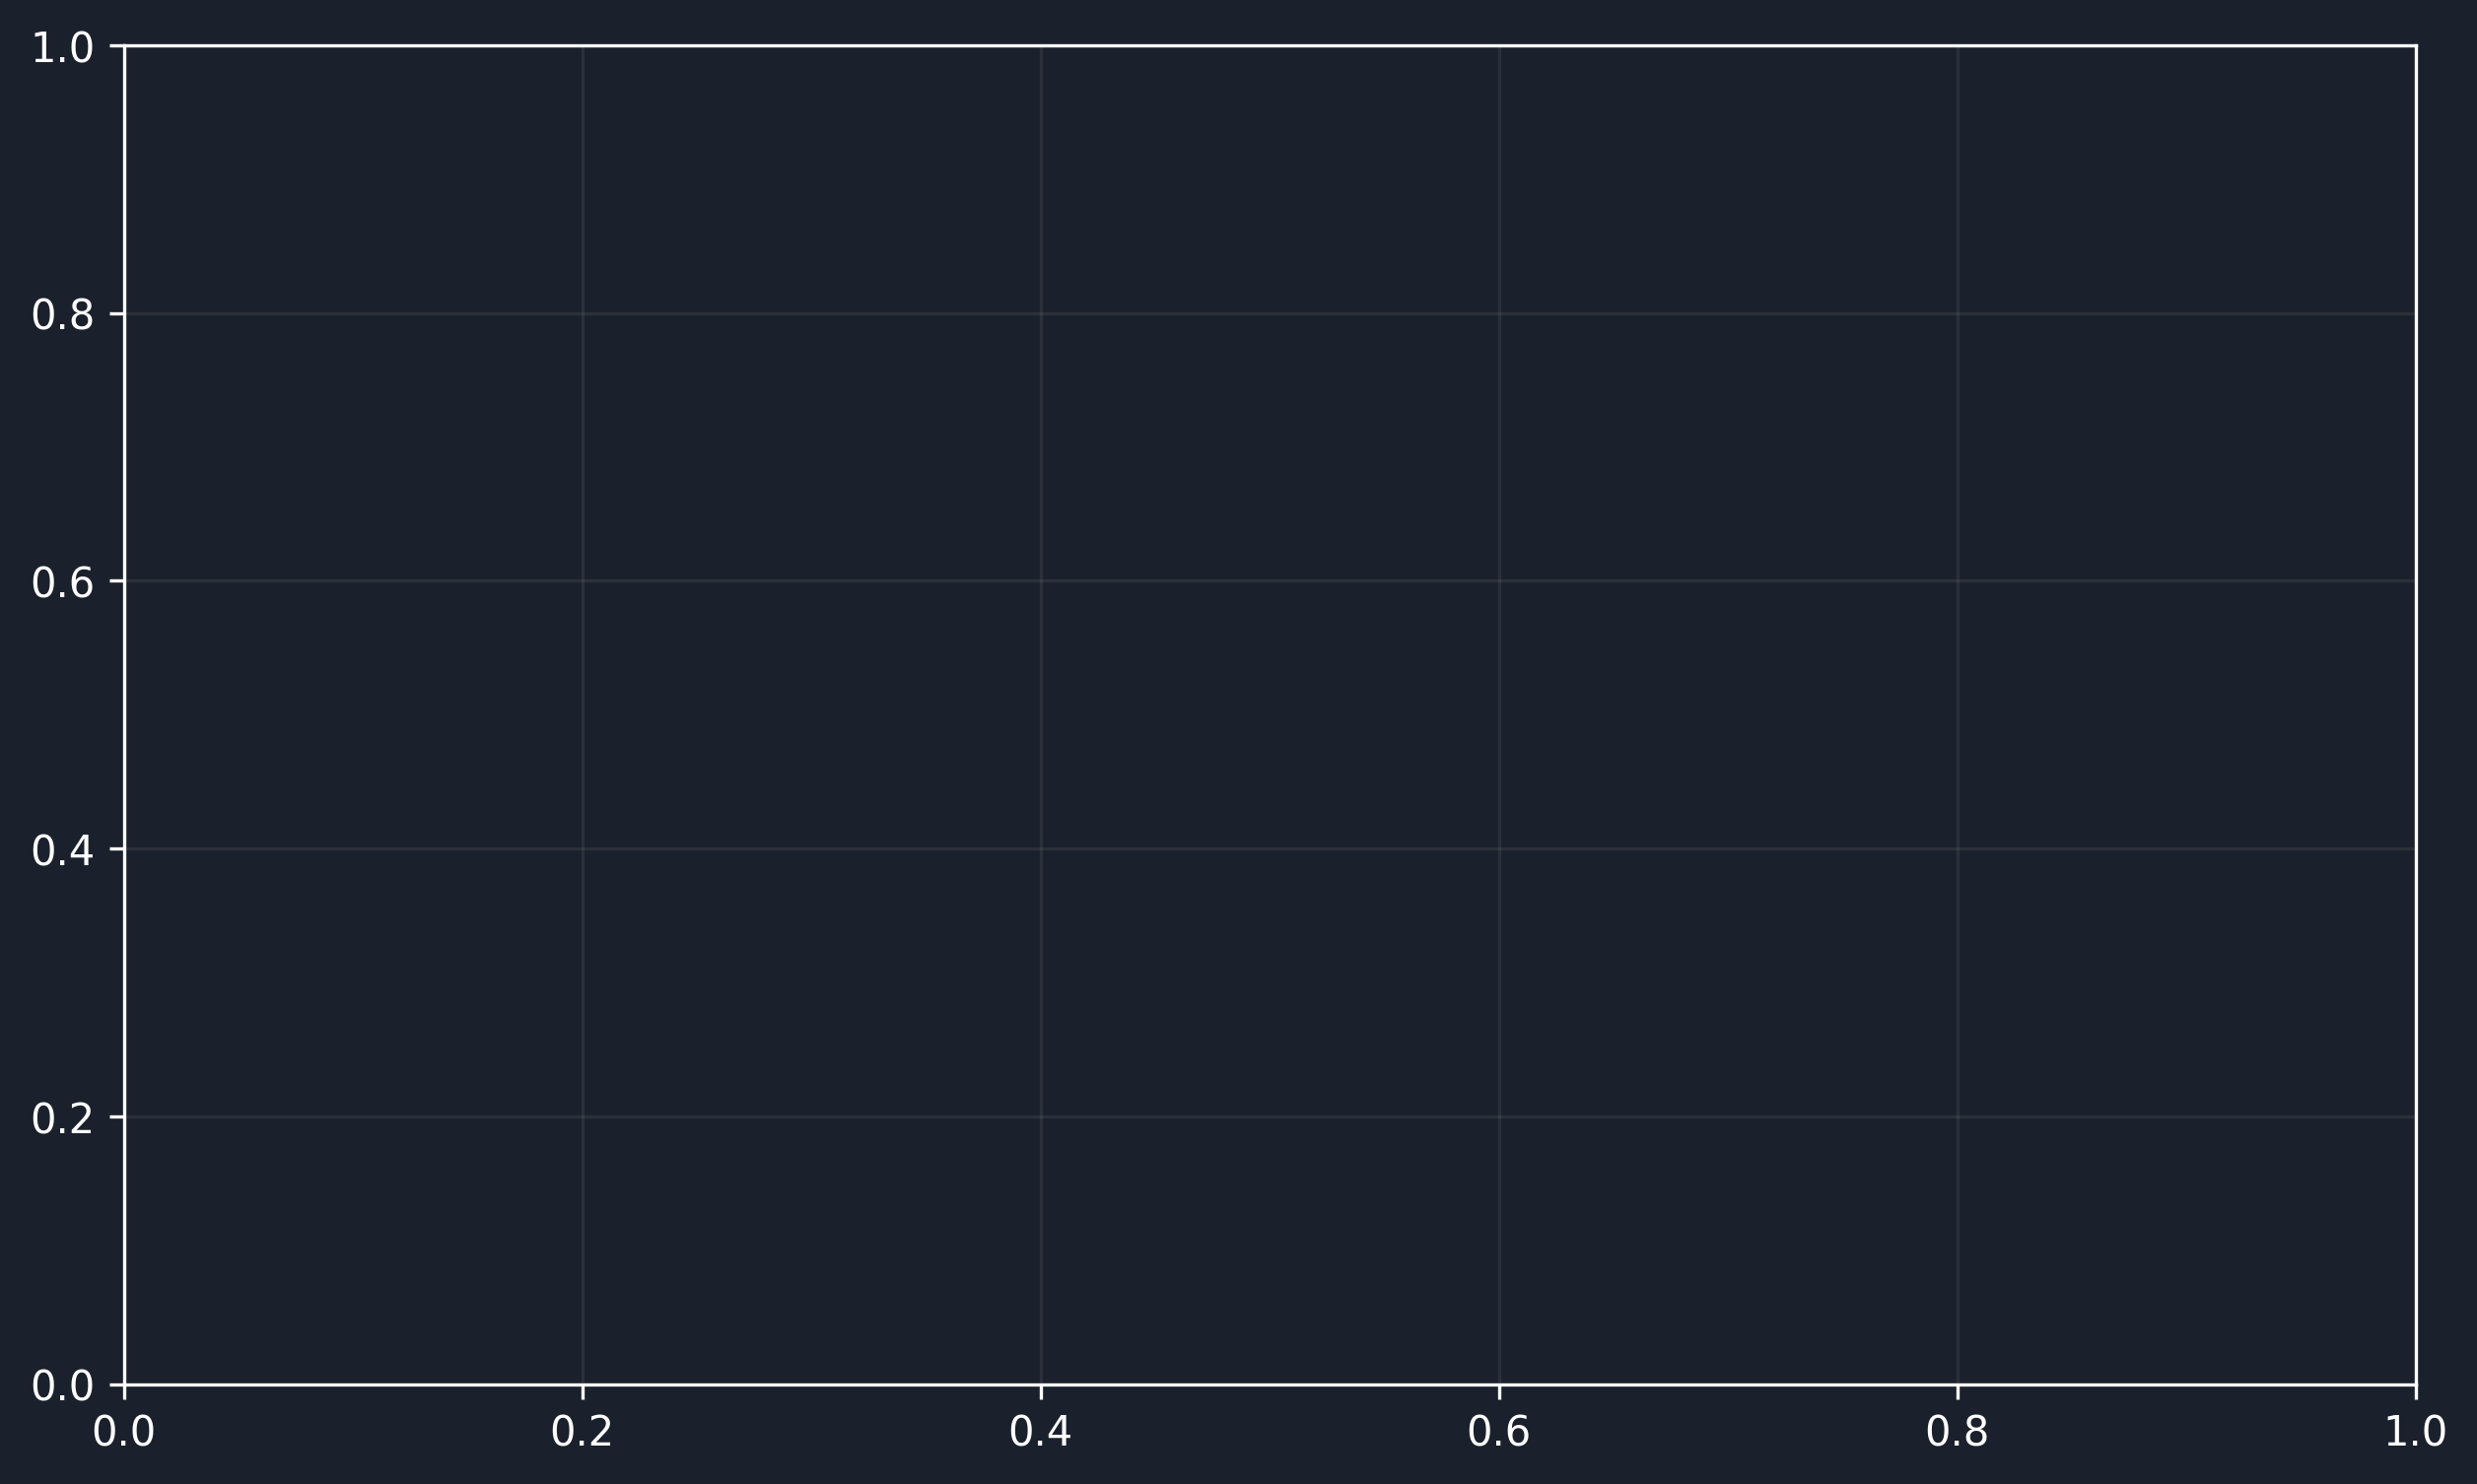

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

set_color(fig, ax)

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)